<a href="https://colab.research.google.com/github/mathewhall100/SIIM-ACR-pneumothorax-model/blob/master/SIIM_ACR_Pneumothorax_Competition_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SIIM-ACR-Pneumothorax Segmentation Competition - Data Analysis


![image.png](attachment:image.png)

## Background
Pneumothorax is a medical problem which occurs when air escapes through a hole in the lung and becomes trapped between the outer lining of the lung (pleura) and the chest wall. As more air accumulates, the lung is compressed and may ultimately collapse on the affected side. Clinical symptoms of pneumothorax are mainly shortness of breath (dyspnea) and chest pain when breathing (pleurisy). Rarely sufficient air accumulates to put pressure on all the contents of the thorac cavity, heart and graet vessels included, which can be fatal if untreated. 

![image.png](attachment:image.png)

Diagnosis is made by clinical examination (reduced chest sounds and hyper-resonance of the chest over the side of the pneumothorax) and confirmatory chest X-ray where pneumothoraces most often show up as a visible plural edge and rim of reduced lung marking around the inside of the chest wall. The collapsed lung may also be hypolucent.

Treatment is usually by inserting a tube through the chest wall into the pleural space to release the trapped air allowing the lung to reinflate, though some smaller less symptomatic pneumothoraces can be managed by aspiration or managed conservatively (no treatment). 

## The competition

Diagnosing a pneumothorax can be present a difficulty to the physician, especially on poor quality films taken in the emergency department as is so often the case. Thus, an aid to identifying pneumothorax disease on chest X-ray may of considerable value to physicians tasked with making the diagnosis. It may also allow better prioritisation of chest X-rays by radiologists nd imaging departments. 

The Kaggle competition challenges us to develop a image recognition model capable of classifying pneumothoraces on chest X-ray and where present segmenting them to show the location of the pneumothorax for physician verification. 

## Get the data

We are provided with the competition dataset downloaded from the Google's health cloud:
* dicom-images-train (contains the training X-rays in dicom format
* train-rle-csv (contains the labels for he training images)
* dicom-images-test (the test images

In [0]:
import os
path = "../input/siim-acr-pneumothorax-segmentation-data/"
os.listdir(path)

['dicom-images-train', 'train-rle.csv', 'dicom-images-test']

In [0]:
# We will need the pydicom library to work with DICOM image files
!pip install pydicom

In [0]:
# import all the other libraries we are going to need
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import fastai
from fastai.vision import *
from fastai.metrics import error_rate
import pydicom

In [0]:
# Training image files
train_path = f'{path}/dicom-images-train'
train_files = os.listdir(train_path);
train_files[:5]

['1.2.276.0.7230010.3.1.2.8323329.10687.1517875225.75979',
 '1.2.276.0.7230010.3.1.2.8323329.10803.1517875225.688629',
 '1.2.276.0.7230010.3.1.2.8323329.13451.1517875245.370774',
 '1.2.276.0.7230010.3.1.2.8323329.13465.1517875245.453652',
 '1.2.276.0.7230010.3.1.2.8323329.4633.1517875183.863332']

Now the train-rle-csv file is more complicated. It contains the image ID (of the corresponding image in train folder) and a label separated by the deliminator ',' .

The label is either 
1. a run length encoded (rle) segmentation mask  (may be more then one per study)
1. or -1 to indicate no pneumothorax

The segmentation masks indicate the 'ground truth' localisation of pneumothraces as drawn by professional radiologists. 

Run length encoding (RLE) is a lossless compresion format used for uncomplicated images with just two, or a small number of, colors. Instead of every pixel being represented by data point(s) as in a standard jpeg or png image, RLE encodes the image as a series of runs of identical pixels reduced to a single value - the length of the run. Run lengths are separated by values indicating the number of pixels between runs. 
RLEs can be converted back to their original segmentation masks using a short piece of code (we will use the 'rle2mask' utility below).

In [0]:
path_labels = f'{path}/train-rle.csv'
df_labels = pd.read_csv(path_labels)
pd.set_option("display.max_colwidth", 100)
print("Number of training image labels: ", len(df_labels))
print(df_labels.head())

Number of training image labels:  11582
                                                   ImageId  \
0   1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090   
1  1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137   
2   1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709   
3  1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312   
4  1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312   

                                                                                         EncodedPixels  
0                                                                                                   -1  
1                                                                                                   -1  
2   175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 ...  
3   407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24...  
4   252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 

In [0]:
# We can also separate the image ID (ImageId) from the encoded segmentation masks (EncodedPixels)
masks = pd.read_csv(path_labels, delimiter=",")

# Masks["ImageId"] now contains the image Id, and masks[ EncodedPixels] contains the label, either a rle encoded mask or -1 
print(f'Image Id: {masks["ImageId"][:1]}')
print(f'Encoded Pixels {masks[" EncodedPixels"][:1]}')

Image Id: 0    1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090
Name: ImageId, dtype: object
Encoded Pixels 0     -1
Name:  EncodedPixels, dtype: object


## Utilities

In [0]:
# Mask functions provided from kaggle competition
# Convert from RLE to mask image 
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [0]:
# Plot a series of images in DICOM format
# Note that the image is in the pixel_array filed of the DICOM file and must be read by pydicom
def plot_many(rows, cols, files):
  f, axarr = plt.subplots(rows, cols, figsize=(9,6))
  for x in range(rows):
    for y in range(cols):
      z=(x*cols)+y
      img = pydicom.read_file(files[z]).pixel_array
      plt.axis('off')
      axarr[x,y].imshow(img, cmap='bone')

In [0]:
# Plots an image from a DICOM pixel array   
def plot_pixel_array(dataset, figsize=(9,6)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

## Examine the training images

In [0]:
# Lets start by looking at the DICOM files
# load DICOM files into train folder and sort 

train = sorted(glob(f'{train_path}/*/*/*.dcm'))
print("Training files: ", len(train))

Training files:  10712


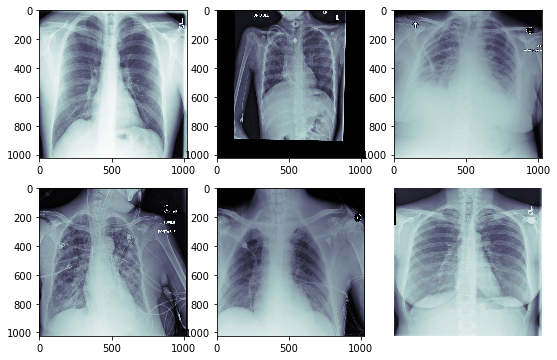

In [0]:
# display some images
plot_many(2, 3, train)

## DICOM image files

DICOM is the industry standard method of storing and transmitting medical image data. In addition to the image itself, DICOM image files contain a wealth of information about the subject of the image (the patient), the study itself and even the referring physician. 
Below is a DICOM image file from the train folder unpacked by pydicom and its data displayed. 
* the 'SOP instance UID' is the image ID and links to the ImageId in the train-rle_csv file
* the 'age' and 'sex' of the patient is given
* the study 'modality' (CR means Chest X-ray) and 'view position' (PA or AP)
* the size of the images in pixels (1024 rows and 1024 cols) is given 
* along with the 'pixel spacing' - the physical distance in the patient in mm represented by the space between the center of two pixels in the image
* finally, the 'pixel array' field actually contains the image as an array of pixels

In [0]:
# The image files also contain DICOM metadata about the study and subject
metadata = pydicom.dcmread(train[0])
print(metadata)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0020) Patient ID                          LO: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [0]:
# We can create a dataframe with the relevant data on patient characteristics and study type.
# At the same time we can check that there are no missing lables since all the imageIds in train (metadata.SOPINstanceUID) should have a coresponding label in masks["ImageId"] 
patients = []
missing = 0

for i in train:
    data = pydicom.dcmread(i)
    patient = {}
    patient["UID"] = data.SOPInstanceUID
    try:
      encoded_pixels = masks[masks["ImageId"] == patient["UID"]].values[0][1]
      patient["EncodedPixels"] = encoded_pixels
    except:
      missing = missing + 1
      
    patient['Age'] = data.PatientAge
    patient['Sex'] = data.PatientSex
    patient['Modality'] = data.Modality
    patient['BodyPart'] = data.BodyPartExamined
    patient['ViewPosition'] = data.ViewPosition
    patient['PixelSpacing'] = data.PixelSpacing 
    patients.append(patient)
      
print("Missing labels: ", missing)
pd.set_option('display.max_colwidth', -1)
df_patients = pd.DataFrame(patients, columns = ["UID", "EncodedPixels", "Age", "Sex", "Modality", "BodyPart", "ViewPosition", "PixelSpacing"])
print("images with labels: ", df_patients.shape[0])
df_patients.head()

Missing labels:  37
images with labels:  10712


,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,PixelSpacing
0,1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027,-1,38,M,CR,CHEST,PA,"[0.168, 0.168]"
1,1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530,-1,10,F,CR,CHEST,AP,"[0.139, 0.139]"
2,1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580,-1,50,F,CR,CHEST,AP,"[0.168, 0.168]"
3,1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397,-1,68,F,CR,CHEST,AP,"[0.139, 0.139]"
4,1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420,-1,65,M,CR,CHEST,AP,"[0.168, 0.168]"


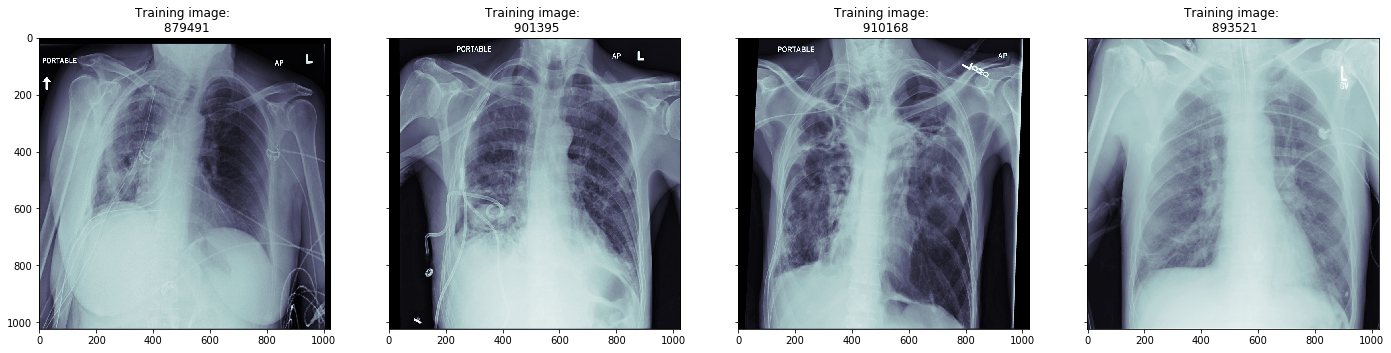

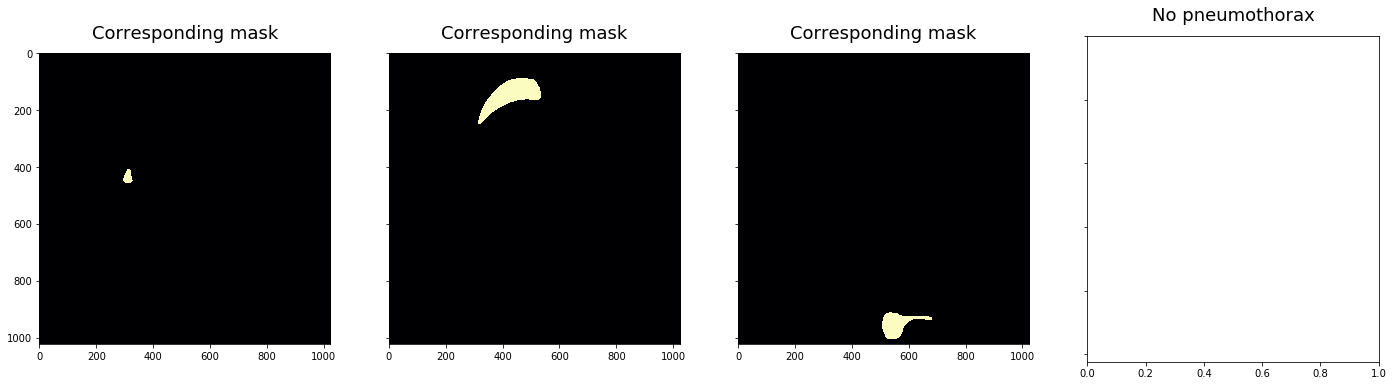

In [0]:
# The image itself is encoded by the 'pixel data' field of the DICOM file
# Once again we can use pydicom to read the 'pixel data' into ian image for us to display
start = 1000   # Starting index of images
num_img = 4 # Total number of images to show
masks_find = []

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*6,6))
for q, file_path in enumerate(train[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    img_title = file_path.split('/')[len(file_path.split('/'))-1]
    ax[q].set_title(f"Training image: \n {img_title.split('.')[len(img_title.split('.'))-2]}")
    
for q, file_path in enumerate(train[start:start+num_img]):
    y = file_path.split('/')[len(file_path.split('/'))-1].replace('.dcm', '')
    masks_find.append(df_patients[df_patients['UID'] == y]['EncodedPixels'])

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*6,6))
for q, mask_img in enumerate(masks_find):
    m = str(mask_img.values[0])
    if m != ' -1': 
        mask_m = rle2mask(m, 1024, 1024)
        mask_m = np.rot90(mask_m, 3)
        mask_m = np.flip(mask_m, axis=1)
        ax[q].imshow(mask_m, cmap=plt.cm.magma)
        ax[q].set_title(f'Corresponding mask', fontsize=18, pad=15)
    else:
        ax[q].set_title(f'No pneumothorax', fontsize=18, pad=15)
    

In [0]:
# While we are here, lets get the average pixel spacing for later calculations
# Pixel spacing is the actual distamce in mm in the patient represented by the space between the center of two pixels in the X-ray image
# Thuis varies between view position and the distance between the patient and Xray machine when the Xray is taken
np_pixelspacing = df_patients["PixelSpacing"].values
sumr = 0
sumc = 0
meanr = 0
meanc = 0
for i in np_pixelspacing:
    sumr += i[0]
    sumc += i[1]
pixel_spacing_row = round(sumr/len(np_pixelspacing), 3)
pixel_spacing_col = round(sumc/len(np_pixelspacing), 3)
print(f"Average row spacing: {pixel_spacing_row}mm")
print(f"Average column spacing: {pixel_spacing_col}mm")

Average row spacing: 0.155mm
Average column spacing: 0.155mm


## Examine the DICOM data

We can now use the df_patients dataframe ceated above from the DICOM data to gain some indights into the competition dataset.

Firstly, we can look at the proportion of pneumothorax vs no pneumothorax in the datset, the number of men vs women and then the proportion of pneumothoraces by gender

In [0]:
all = len(df_patients)

def to_pct(inp, all):
    return round(inp/all*100, 2)

def prop_calc(num, all):
    num1 = num
    num2 = all - num1
    num1_pct = to_pct(num1, all)
    num2_pct = to_pct(num2, all)
    return [num1, num2, num1_pct,num2_pct]

# What are the proportions of men and women in the dataset
men, women, men_pct, women_pct = prop_calc(len(df_patients[df_patients["Sex"] == "M"]), all)
# What are the proportions of patients with vs without pneumothorax
without_ptx, with_ptx, without_ptx_pct, with_ptx_pct = prop_calc(len(df_patients[df_patients["EncodedPixels"] == " -1"]), all)
# What are the proportions of men/women with/without pneumothorax
men_without_ptx, men_with_ptx, men_without_ptx_pct, men_with_ptx_pct = prop_calc(len(df_patients[(df_patients["Sex"] == "M") & (df_patients["EncodedPixels"] == " -1")]), men)
women_without_ptx, women_with_ptx, women_without_ptx_pct, women_with_ptx_pct = prop_calc(len(df_patients[(df_patients["Sex"] == "F") & (df_patients["EncodedPixels"] == " -1")]), women)

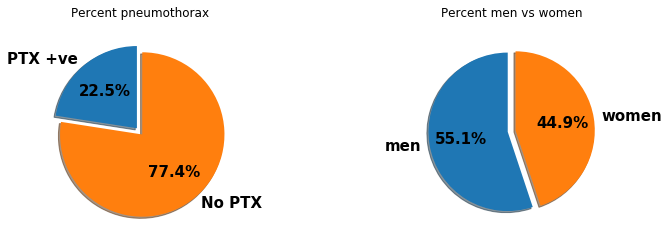

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

font = {'family': 'sans-serif', 'weight': 'bold','size': 15}
plt.rc('font', **font)
plt.rc('axes', titlesize=20)
explode = (0, 0.1)

labels = 'PTX +ve', 'No PTX'
data = [with_ptx_pct, without_ptx_pct]
ax1.title.set_text('Percent pneumothorax')
ax1.pie(data, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

labels = 'men', 'women'
data = [men_pct, women_pct]
ax2.title.set_text('Percent men vs women')
ax2.pie(data, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')



plt.subplots_adjust(wspace=1.0, hspace=0.5)
plt.show()

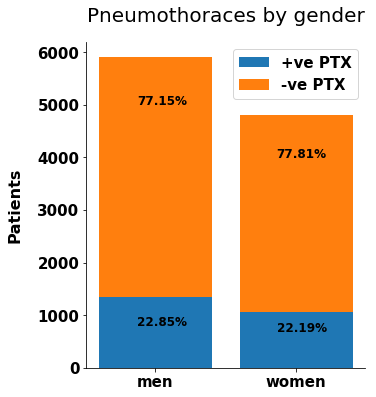

In [0]:
ptx = [men_with_ptx, women_with_ptx]
no_ptx = [men_without_ptx, women_without_ptx]

fig, ax = plt.subplots(1, 1, figsize=(5,6))
p1 = ax.bar([0,1], ptx)
p2 = ax.bar([0,1], no_ptx, bottom=ptx)
plt.title('Pneumothoraces by gender', pad=20)
plt.ylabel('Patients', fontsize=16,weight='bold', labelpad=15)
plt.xticks([0,1], ('men', 'women'))
legend = plt.legend((p1[0], p2[0]), ('+ve PTX', '-ve PTX'), frameon=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.set_facecolor((0,0,0,0))
ax.text(-0.13,800,f'{men_with_ptx_pct}%', fontsize=12)
ax.text(0.86,700,f'{women_with_ptx_pct}%', fontsize=12)
ax.text(-0.13,5000,f'{men_without_ptx_pct}%', fontsize=12)
ax.text(0.86,4000,f'{women_without_ptx_pct}%', fontsize=12)

plt.show()


Thus, the datset contains more male patients than female (55% vs 45%) but the proportion of pneumothoraces is the same for both genders at around 22%

Next lets look at the distribution of patients and pneumothoraces by age.

In [0]:
# Convert df_patients['Age'] column to numpy aray of integers and sort it low to high
df_patients["age"] = pd.to_numeric(df_patients["Age"], downcast='integer')
sorted_ages = np.sort(df_patients["age"].values)
print(f'Distribution of ages: {sorted_ages}')

Distribution of ages: [  1   2   2   2 ...  90  94 148 413]


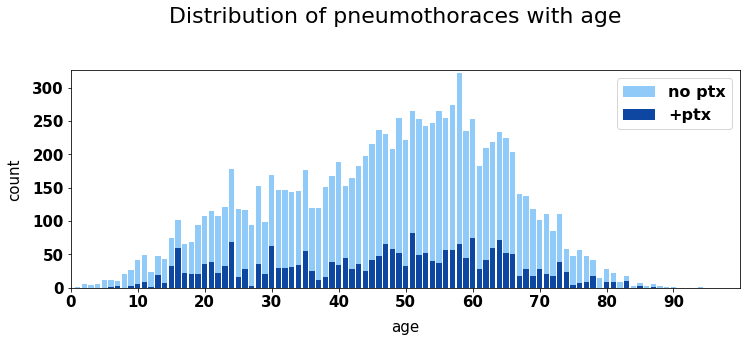

In [0]:
bins = [i for i in range(100)]
np_pts_with_ptx = np.array(df_patients[(df_patients["EncodedPixels"] != ' -1')]["Age"].values).astype(int)
pts_with_ptx = (np.histogram(np_pts_with_ptx, bins=bins))[0]
np_pts_all = np.array(df_patients["Age"].values).astype(int)
pts_all = (np.histogram(np_pts_all, bins=bins))[0]

fig, ax = plt.subplots(ncols=1,figsize=(12, 4))
fig.suptitle("Distribution of pneumothoraces with age", fontsize=22, y=1.1)
ax.margins(x=0.1, y=0.01)
m1 = ax.bar(bins[:-1], pts_all, color='#90CAF9')
m2 = ax.bar(bins[:-1], pts_with_ptx, color='#0D47A1')
plt.xlabel("age", labelpad=10)
plt.xticks([i*10 for i in range(0, 10)])
plt.xlim([0,len(bins)])
plt.ylabel("count", labelpad=10)
ax.legend((m1[0], m2[0]), ('no ptx', '+ptx'), prop={'size': 16})

plt.show()

In contrast to clinial expectation, where the likelyhood of a patient having an chest X-ray steadily increases with age, the above histogram indicates a more binomial looking distribution. Spontaneous pneumothorax is most common in younger patients and so it is understandable that this group is deliberately overrepresented in the dataset but it would appear that older patients (over 70yrs) are underrepresented. 

## Examine the labels

In [0]:
# Separate out the DICOM data for all patients with a pneumothorax
df_patients_ptx = df_patients[df_patients['EncodedPixels'] != " -1"]

Pneumothoraces can be bilateral and in some cases, on 2D X-ray, may appear as separate areas within the same lung (though in vivo they are almost always continuous in 3D space of the lung)
Thus we would expect there to be more than one RLE in some of the labels, 

In [0]:
# We can identify multiple RELs in the label RLE by looking for non-contigous runs. 
# Non-contigous runs are identified where there is a distance of greater than 1024 (the width of one row) between pixel runs
np_masks = np.array(df_patients_ptx['EncodedPixels'].values)
print(f'Expected num labels: {len(np_masks)}')
masks_x = []
counts = []
missing = 0
count = 0
for x in range(len(np_masks)):
    try:
        strs = np_masks[x].split(" ")
        strs.pop(0)
        ints = list(map(int, strs))
        for i in ints:
            if i > 1025: count = count+1
        counts.append(count)
        if count > 7: masks_x.append(np_masks[x])
        count = 0
    except: # error if label is missing or nan
        missing = missing +1 
print(f'Num labels counted: {len(counts)}')
print(f'missing labels: {missing}')

nums = [' ','patients:          ']
for x in range (20):
    nums.append(str(counts.count(x)))

df = pd.DataFrame([nums[1:15]], columns = ['non-contigous RLEs:','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',]) 
print()
print(df.to_string(index=False))
print()


Expected num labels: 2416
Num labels counted: 2379
missing labels: 37

non-contigous RLEs:  0     1   2   3   4  5  6  7  8  9 10 11 12
patients:            1  2263  64  21  11  7  3  3  2  2  1  1  0



The vast majority of labels contain a single contingous RLE representing a single pneumothorax as expected. However, a small number have two perhaps representing a bilateral pneumothorax (usual cause being trauma). However, it is clinically unlikely any patient has 3 or more separate pneumothoraces, so let's plot those masks with more than 6 non-contigous RLEs to see what is going on. 

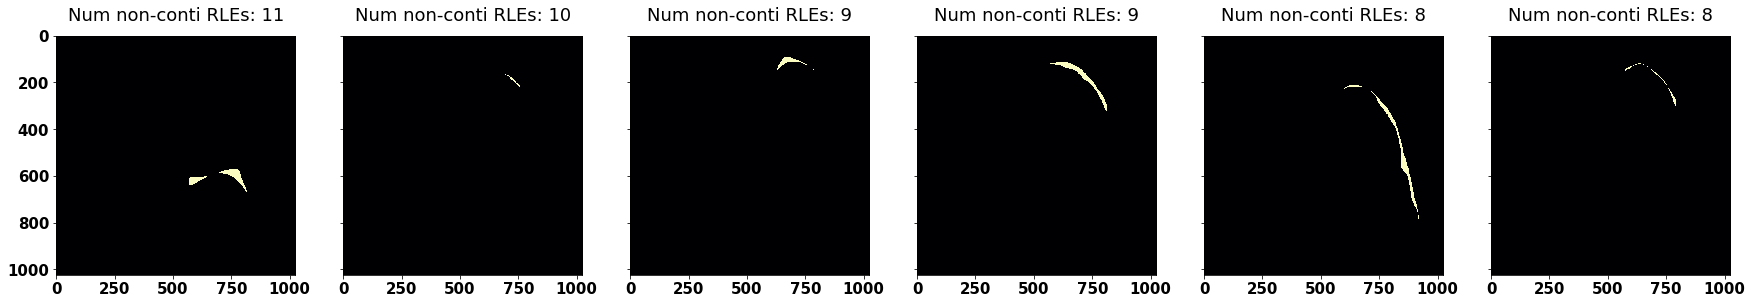

In [0]:
# Plot masks with > 6 non-contigous RLEs
# Use the rle2mask method from the utilities above to convert the RLE to an segmentation mask
num_img = 5, 
num_rle = ['11', '10', '9', '9', '8', '8']
fig, ax = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(30,6))
for q, mask_img in enumerate(masks_x):
    mask_img = rle2mask(mask_img, 1024, 1024)
    mask_img = np.rot90(mask_img, 3)
    mask_img = np.flip(mask_img, axis=1)
    ax[q].imshow(mask_img, cmap='magma')
    ax[q].set_title(f'Num non-conti RLEs: {num_rle[q]}', fontsize=18, pad=15)
    if q == num_img: break

So it looks like the high number of non-contigous RLEs in some labels is an artifact of the labelling and in fact they are all part of a clinically contiguous pneumothorax. Thus, we can ignore this,

## What is the distribution of pneumothorax sizes?

The size of pneumothoraces can be obtained by converting the RLEs to segmentation masks and summing the pixels of each mask.
Note that the view position, (PA or AP) has an effect on the apparant size of objects on X-ray images with a tendancy for objects to appear larger on AP films (due to increased beam spreading). Thus lets separate out PA from AP films when we calculate pneumothorax sizes.

In [0]:
df_patients_ptx = df_patients[df_patients['EncodedPixels'] != " -1"]
np_masks = np.array(df_patients_ptx['EncodedPixels'].values)

area_pixels= []
area_pixels_all = []
area_pixels_AP = []
area_pixels_PA = []

missing = 0

for pt in df_patients_ptx.values:
    try:
        mask = rle2mask(pt[1], 1024, 1024)
        pixels = np.count_nonzero(mask)
        area_pixels_all.append(pixels)
        if pt[6] == 'AP':   
            area_pixels_AP.append(pixels)
        else: 
            area_pixels_PA.append(pixels)
    except:
        missing = missing + 1

print("missing labels", missing)

missing labels 37


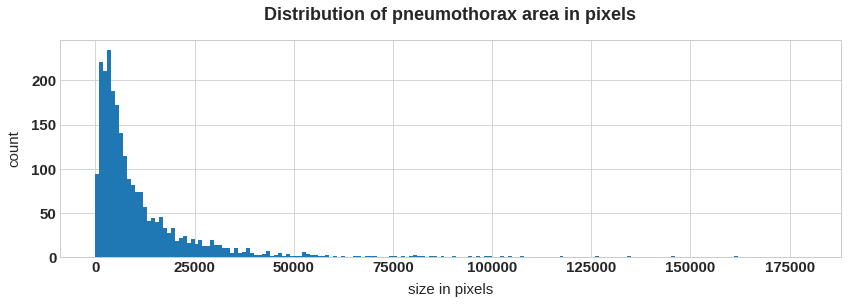

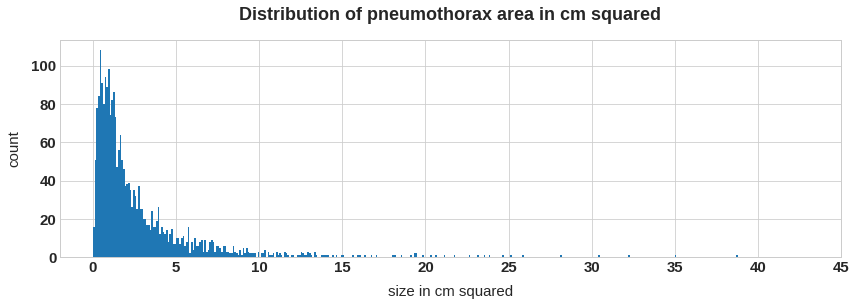

In [0]:
# Examine distribution of pneumothorax sizes 
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14, 4))
plt.hist(np.array(area_pixels_all), bins=[i*1000 for i in range(180)])
plt.title("Distribution of pneumothorax area in pixels", fontsize=18, pad=20, fontweight='bold')
plt.xlabel("size in pixels", labelpad=8)
plt.xticks([i*25000 for i in range(8)])
plt.ylabel("count", labelpad=10)
plt.show()

# We can convert pixels on a dicom image to distance in the patient using the pixel-spacing variable in the dicom data
# Earlier we calculated the mean pixel spacing for the dataset (pixel_spacing_row and pixel_spacing_col)
# These can be used to calculate the 2d areas of the pneumothoraces in the patient
# Assuning a single pixel takes up an area of pixel_spacing_row * pixel_spacing_col
# For simplicity we have taken an average of all the pixel spacings across the dataset

area_cm_sq = [(i * (pixel_spacing_row * pixel_spacing_col))/100 for i in area_pixels_all]

plt.figure(figsize=(14, 4))
plt.hist(area_cm_sq, bins=[i*0.1 for i in range(400)]) 
plt.title("Distribution of pneumothorax area in cm squared", fontsize=18, pad=20, fontweight='bold')
plt.xlabel("size in cm squared", labelpad=10)
plt.xticks([i*5 for i in range(10)])
plt.ylabel("count", labelpad=10)
plt.show()

Most pneumothoraces are quite small, less than 10cm squared. This is surprising as my clinical experience is that once they become symptomatic, most are quite large. Possible explanations: 
1. professional radiologists spot many more smaller pneumothoraces than on-the-job clinicians, or 
2. interestingly many of the pneumothoraces in the dataset have been treated as evidenced by a visible chest tube on the X-ray. Treatment reduces the size of the pneumothrax considerably, usually leaving small residual disease at the apex of the lung. Since larger pneumothoraces are most likely to have been treated, this would skew the size distribution considerably. 

## Is there a size difference between pneumothorax sizes on PA vs AP views?

PA (posterior-anterior) films are standard but require the patient to stand upright facing the X-ray film while the X-ray beam is 'shot' from behind. 
However, many patiests are too unwell to stand and in this case a AP (anterior-posterior) film is taken where the patient lies flat or sits up in bed with the X-ray plate behind them and the beam is shot from a mobile X-ray machine in front of the patient.
Thus, it might be expected that the AP studies represent a more unwell group of patients (who can't stand up) than the PA studies (where the patients can stand). 
Of course, they may be more unwell because of many factors, but where the diagnosis is pneumothorax it may be because they have a larger pneumothorax and are therefore more symptomatic
So we might expect the AP studies group to have, on average, larger pneumothoraces than the PA group. Let's test that hypothesis!

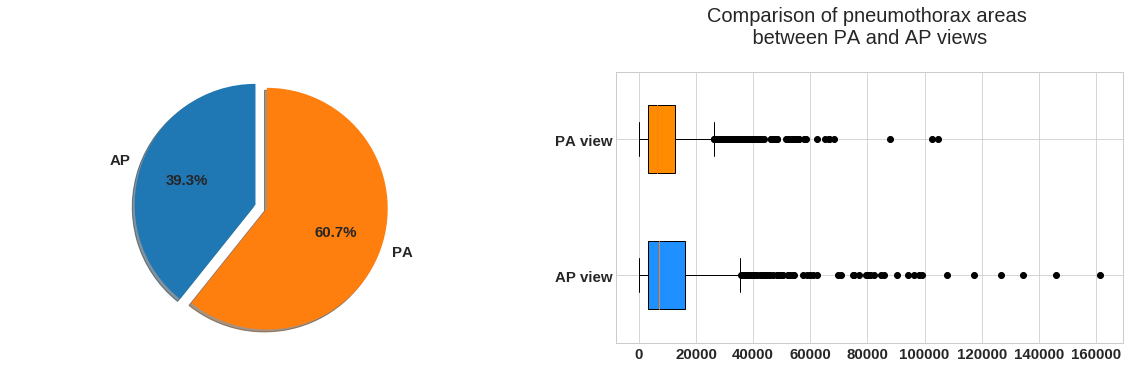

In [0]:
# Calculate the proportion of AP vs PA studies
AP_studies = len(df_patients[df_patients['ViewPosition'] == 'AP'])
PA_studies = len(df_patients[df_patients['ViewPosition'] == 'PA'])
AP_studies_pct = round((AP_studies/(AP_studies+PA_studies))*100, 2)
PA_studies_pct = round((PA_studies/(AP_studies+PA_studies))*100, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
labels = 'AP', 'PA'
data = [AP_studies_pct, PA_studies_pct]
explode = (0, 0.1)
ax1.pie(data, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Study view: AP vs PA ', pad=5)
ax1.axis('equal') 

box = ax2.boxplot([np.array(area_pixels_AP), np.array(area_pixels_PA)], 0, 'black', 0, patch_artist=True, widths=0.5)
plt.yticks([1, 2], ['AP view', 'PA view'])
colors = ['dodgerblue', 'darkorange']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.title('Comparison of pneumothorax areas \n between PA and AP views \n')
      
plt.show()

## What are the most common locations for pneumotharax in this study?

In [0]:
# Sum all masks wit pneumothoraces in the dataset
mask_sum = np.array([[0 for i in range(1024)] for j in range(1024)])

for pt in df_patients_ptx.values:
    try :
        mask = rle2mask(pt[1], 1024, 1024)
        mask_sum = mask_sum + mask
    except:
        missing = missing + 1
# need to rotate and flip the masks to display correctly       
mask_sum = np.rot90(mask_sum, 3)
mask_sum = np.flip(mask_sum, axis=1)

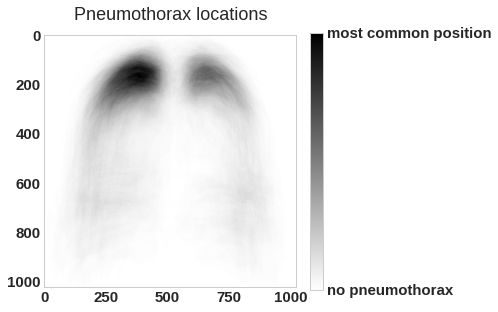

In [0]:
# Plot as a single image with colorbar

fig = plt.figure(figsize=(17, 5))
basic_palette = sns.color_palette()
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax1.imshow(mask_sum, cmap='binary')
ax1.set_title("Pneumothorax locations", fontsize=18, pad=15)

#colorbar
maxval = np.max(mask_sum)
cmap = plt.get_cmap('binary', maxval)

norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ticks=[1/(maxval+1)/2, 0.5, 1-1/(maxval+1)/2]

cb = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax1) #ticks and boundaries
cb.ax.set_yticklabels(["no pneumothorax", "most common position"]) #label of colormap
cb.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.show()

The most common location for pneumothorax in the dataset is the top, or apex, of the lungs. This is clinically expected, and particularly if many of the larger pneumothoraces have been treated. 

## Are there any differences in pneumothorax location between men and women, PA vs AP films and across the ages?

In [0]:
# Sum the masks with pneumothoraces togather grouping them by male vs female, PA vs AP and by age quartile.
def empty_array(): 
    return np.array([[0 for i in range(1024)] for j in range(1024)])

mask_sum = empty_array()
ap_sum = empty_array()
pa_sum = empty_array()
men_sum = empty_array()
women_sum = empty_array()
ages_sum = [[],[],[],[]]
for x in range(4):
    ages_sum[x] = empty_array()

ap = 0
pa = 0
men = 0
women = 0
ages = [i*0 for i in range(4)]
missing = 0

for pt in df_patients_ptx.values:
    try :
        mask = rle2mask(pt[1], 1024, 1024)
        mask_sum = mask_sum + mask
        if pt[6] == 'AP':
            ap_sum = ap_sum + mask
            ap += 1
        else:
            pa_sum = pa_sum + mask
            pa +=1
        if pt[3] == 'M':
            men_sum = men_sum + mask
            men += 1
        else:
            women_sum = women_sum + mask
            women += 1
        age_cats = [25, 50, 75, 100]
        for i in age_cats:
            if int(pt[2]) < i:
                idx = int(i/25 - 1)
                ages_sum[idx] = ages_sum[idx] + mask
                ages[idx] += 1
                break
    except:
        missing = missing + 1
        
mask_sum = np.rot90(mask_sum, 3)
mask_sum = np.flip(mask_sum, axis=1)
ap_sum = np.rot90(ap_sum, 3)
ap_sum = np.flip(ap_sum, axis=1)
pa_sum = np.rot90(pa_sum, 3)
pa_sum = np.flip(pa_sum, axis=1)
men_sum = np.rot90(men_sum, 3)
men_sum = np.flip(men_sum, axis=1)
women_sum = np.rot90(women_sum, 3)
women_sum = np.flip(women_sum, axis=1)
for i in range(4):
    ages_sum[i] = ages_sum[i]/ages[i]
    ages_sum[i] = np.rot90(ages_sum[i], 3)
    ages_sum[i] = np.flip(ages_sum[i], axis=1)

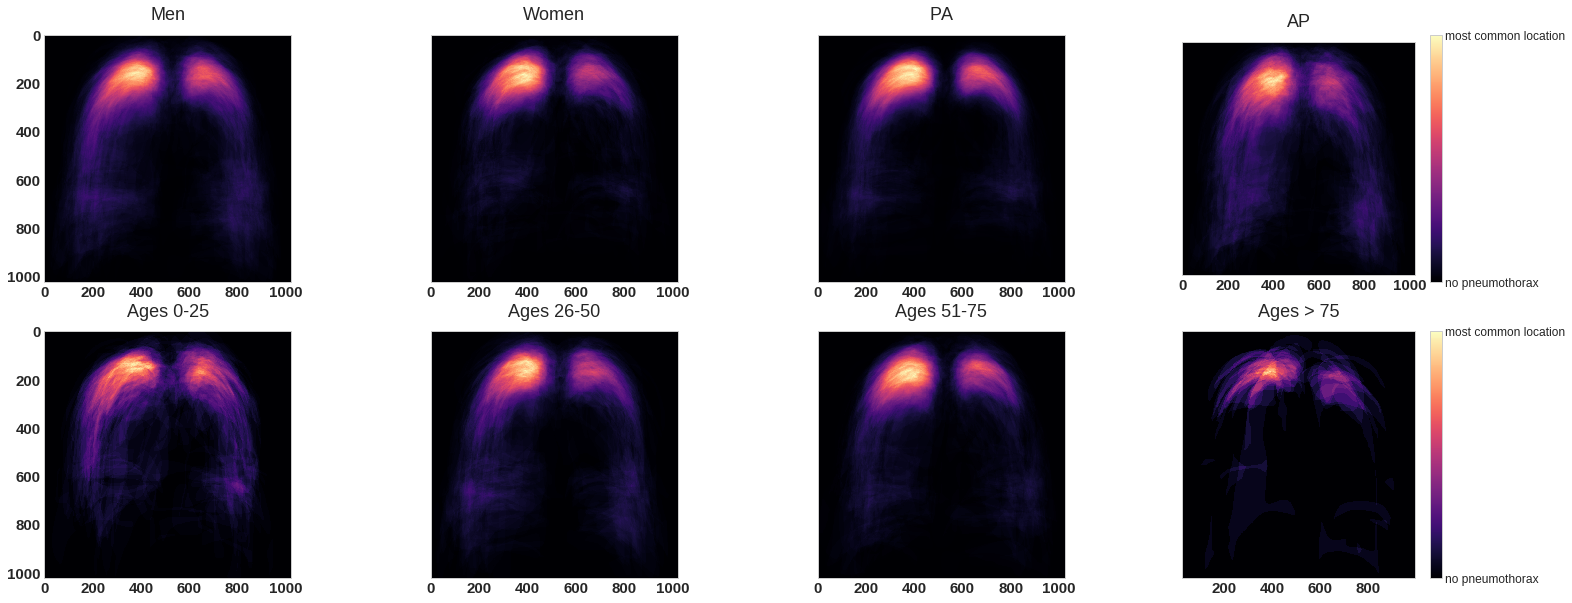

In [0]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2,ncols=4, sharey=True, figsize=(26, 10))
font = {'family': 'sans-serif', 'weight': 'normal','size': 12}
plt.rc('font', **font)
plt.rc('axes', titlesize=20)
basic_palette = sns.color_palette()

ax1.imshow(men_sum, cmap='magma')
ax1.set_title("Men", fontsize=18, pad=15)

ax2.imshow(women_sum, cmap='magma')
ax2.set_title("Women", fontsize=18, pad=15)

ax3.imshow(pa_sum, cmap='magma')
ax3.set_title("PA", fontsize=18, pad=15)

ax4.imshow(ap_sum, cmap='magma')
ax4.set_title("AP", fontsize=18, pad=15)

#colorbar
maxval = np.max(mask_sum)
cmap = plt.get_cmap('magma', maxval)
norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb_1 = plt.colorbar(sm, ticks=[0,1], ax=ax8) 
cb_1.ax.set_yticklabels(["no pneumothorax", "most common location"]) 
cb_1.ax.yaxis.set_label_position('left')

ax5.imshow(ages_sum[0], cmap='magma')
ax5.set_title("Ages 0-25", fontsize=18, pad=15)

ax6.imshow(ages_sum[1], cmap='magma')
ax6.set_title("Ages 26-50", fontsize=18, pad=15)

ax7.imshow(ages_sum[2], cmap='magma')
ax7.set_title("Ages 51-75", fontsize=18, pad=15)

ax8.imshow(ages_sum[3], cmap='magma')
ax8.set_title("Ages > 75", fontsize=18, pad=15)

#colorbar
maxval = np.max(mask_sum)
cmap = plt.get_cmap('magma', maxval)
norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb_2 = plt.colorbar(sm,ticks=[0, 1], ax=ax4) 
cb_2.ax.set_yticklabels(["no pneumothorax", "most common location"])
cb_2.ax.yaxis.set_label_position('left')

for ax in fig.axes:
    ax.grid(False)
plt.subplots_adjust(wspace = 0.33)
plt.axis('equal')
    
plt.show()

For all the subgroups examined the most common location remains apical (top of the lungs) with a preference for the right side. Judging by the area covered by the overlayed masks, men tend to have larger pneumothoraces than women AP fils have larger pneumothoraces than PA films, and pneumothorax size decreases with age becoming more concentrated in the apex in older patients. 